# Nested Optimizer Nelder Mead + Linear Regression

In this exercise we are going to fit simulated data using a combination of a Nelder Mead and linear regression optimizer. This method was utilized in my own research to fit the [power spectrum in cosmology](https://arxiv.org/pdf/1510.03554). 

First we should go over polynomial fitting with linear regression. 

**Polynomial Fitting**

Consider a polynomial 
\begin{equation} 
y(x) = a_0 + a_1 x + a_2 x^2 + \cdots + a_N x^N. 
\end{equation} 
This equation may seem non-linear, but it is actually **linear in the parameters** $a_0, a_1, \ldots, a_N$. We can rewrite this as a linear system by treating each power of $x$ as a separate feature.

For a dataset with $M$ observations $(x_i, y_i)$ where $i = 1, 2, \ldots, M$, we can express the problem in matrix form:
\begin{equation}
\mathbf{y} = \mathbf{A} \mathbf{a}
\end{equation}
where $\mathbf{y}$ is the vector of observed values, $\mathbf{a} = [a_0, a_1, a_2, \ldots, a_N]^T$ is the vector of coefficients we want to find, and $\mathbf{A}$ is the design matrix:
\begin{equation}
\mathbf{A} = \begin{bmatrix}
1 & x_1 & x_1^2 & \cdots & x_1^N \\
1 & x_2 & x_2^2 & \cdots & x_2^N \\
\vdots & \vdots & \vdots & \ddots & \vdots \\
1 & x_M & x_M^2 & \cdots & x_M^N
\end{bmatrix}.
\end{equation}

The least squares solution can be found by solving the Normal equations. Below, we illustrate the method using Singular Value Decomposition (SVD). In practice, you should use a professional-grade package like scikit-learn or NumPy's polynomial fitting routines. Below is example code for the polynomial fit. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fmin

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)

# True polynomial parameters: y = a0 + a1*x + a2*x^2
a0_true_poly = 1.0
a1_true_poly = 2.0
a2_true_poly = -0.5

# Generate x data (random uniform sampling)
n_samples = 500
xmin=0
xmax=10
x_poly = np.random.uniform(xmin, xmax, size=n_samples)
x_poly = np.sort(x_poly)  # Sort for easier plotting

# Calculate clean y values
y_clean_poly = a0_true_poly + a1_true_poly*x_poly + a2_true_poly*x_poly**2

# Add noise (5% relative to max signal)
noise_level = 0.05
noise_poly = np.random.normal(0, noise_level * np.max(np.abs(y_clean_poly)), size=n_samples)
y_noisy_poly = y_clean_poly + noise_poly

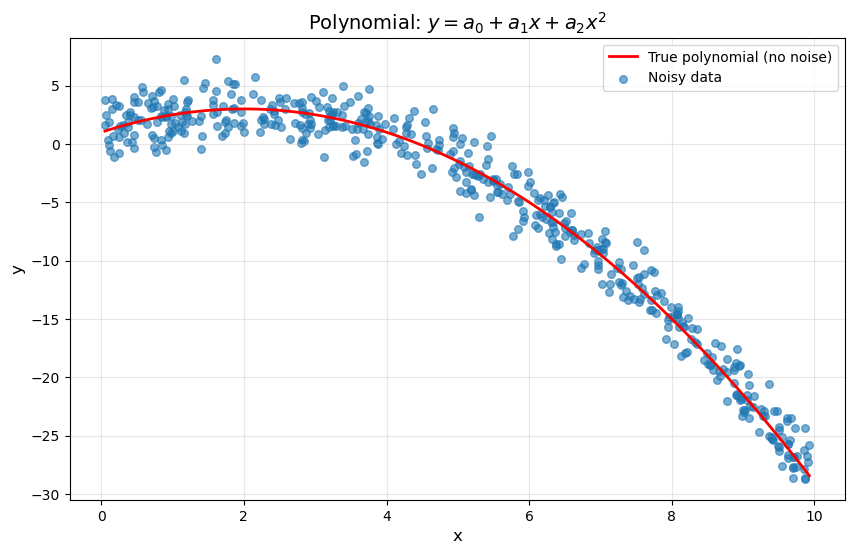

True polynomial parameters:
a0 = 1.0, a1 = 2.0, a2 = -0.5
x range: [0.05, 9.93]


In [3]:
# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(x_poly, y_clean_poly, linewidth=2, color="red", label='True polynomial (no noise)')
plt.scatter(x_poly, y_noisy_poly, alpha=0.6, s=30, label='Noisy data')
plt.xlabel('x', fontsize=12)
plt.ylabel('y', fontsize=12)
plt.title('Polynomial: $y = a_0 + a_1 x + a_2 x^2$', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.show()

print(f"True polynomial parameters:")
print(f"a0 = {a0_true_poly}, a1 = {a1_true_poly}, a2 = {a2_true_poly}")
print(f"x range: [{x_poly.min():.2f}, {x_poly.max():.2f}]")

**Solve by SVD**

In [4]:
# Build design matrix A for polynomial: y = a0 + a1*x + a2*x^2
A_poly = np.column_stack([
    np.ones_like(x_poly),    # column for a0
    x_poly,                   # column for a1
    x_poly**2                 # column for a2
])

# Solve using SVD: A @ coeffs = y_noisy
U, s, Vt = np.linalg.svd(A_poly, full_matrices=False)
coeffs_poly = Vt.T @ np.diag(1/s) @ U.T @ y_noisy_poly

# Extract coefficients
a0_fit, a1_fit, a2_fit = coeffs_poly

# Calculate fitted y values
y_fit_poly = a0_fit + a1_fit*x_poly + a2_fit*x_poly**2

# Calculate MSE
mse_poly = np.mean((y_noisy_poly - y_fit_poly)**2)

print("\nTrue parameters:")
print(f"  a0 = {a0_true_poly:.4f}")
print(f"  a1 = {a1_true_poly:.4f}")
print(f"  a2 = {a2_true_poly:.4f}")

print("\nFitted parameters:")
print(f"  a0 = {a0_fit:.4f}")
print(f"  a1 = {a1_fit:.4f}")
print(f"  a2 = {a2_fit:.4f}")

print("\nParameter errors:")
print(f"  Δa0 = {abs(a0_fit - a0_true_poly):.4f}")
print(f"  Δa1 = {abs(a1_fit - a1_true_poly):.4f}")
print(f"  Δa2 = {abs(a2_fit - a2_true_poly):.4f}")

print(f"\nMSE: {mse_poly:.6f}")


True parameters:
  a0 = 1.0000
  a1 = 2.0000
  a2 = -0.5000

Fitted parameters:
  a0 = 1.0652
  a1 = 1.9001
  a2 = -0.4869

Parameter errors:
  Δa0 = 0.0652
  Δa1 = 0.0999
  Δa2 = 0.0131

MSE: 2.028308


**Non-Linear Model**

The linearization method we used for polynomial modeling does not always work. Consider the damped polynomial 
\begin{equation} 
y = (a_0 + a_1 x + a_2 x^2)e^{-kx}, 
\end{equation} 
where $a_0$, $a_1$, $a_2$, and $k$ are model parameters. This equation cannot be linearized through a simple transformation. If we attempt to take the natural logarithm, we obtain
\begin{equation}
\ln y = \ln(a_0 + a_1 x + a_2 x^2) - kx,
\end{equation}
but the logarithm of a sum cannot be simplified further. Unlike models such as $y = c e^{-kx}$ (which linearizes to $\ln y = \ln c - kx$), the polynomial sum inside the exponential prevents us from separating the parameters into a linear form.

The problem lies in the parameter $k$. You cannot define new features, such as $x e^{-kx}$, because you do not know $k$ beforehand. If $k$ were known, the model would become linear in the remaining parameters, and standard linear regression could be applied.

The fundamental issue is that the model is **non-linear in the parameter $k$**, even though it is linear in the parameters $a_0$, $a_1$, and $a_2$ for any fixed value of $k$. This mixed structure suggests the need for an alternative approach. 

**Nelder-Mead + Linear Regression**

We separate the linear and non-linear components of the model. We take a two-stage process: In stage 1, we solve for the coefficients $a_0$, $a_1$, $a_2$ using a standard least squares method (via SVD). The non-linear parameter $k$ is solved using the Nelder-Mead algorithm; we will use SciPy's `fmin` function to implement this. Our optimization method requires a loss function—we choose the mean squared error (MSE).

Here is how the nested process works:

The Nelder-Mead algorithm searches through $k$-space by repeatedly calling the loss function. For each candidate value of $k$ selected by Nelder-Mead, the problem becomes linear in the remaining parameters. We then solve for the optimal coefficients $a_0$, $a_1$, $a_2$ using linear regression. With these optimal linear coefficients, we compute the mean squared error between the model predictions and the observed data. This MSE value is then reported back to the Nelder-Mead algorithm, which uses it to decide the next value of $k$ to try. This process continues until convergence.

The code below implements this nested optimization approach with simulated data. We use SVD to solve the linear regression component for the coefficients $a_0$, $a_1$, $a_2$ at each iteration. 

In [5]:
# True model: y = (a0 + a1*x + a2*x^2) * exp(-k*x)
a0_true = 1.0
a1_true = 2.0
a2_true = -0.5
k_true = 0.3

In [6]:
xmin=0
xmax=10
n_samples = 500

x = np.random.uniform(xmin, xmax, size=n_samples)
x = np.sort(x)

In [7]:
y_clean = (a0_true + a1_true*x + a2_true*x**2) * np.exp(-k_true*x)

In [8]:
noise_level = 0.05  # 5% relative noise
noise = np.random.normal(0, noise_level * np.max(y_clean), size=len(x))
y_noisy = y_clean + noise

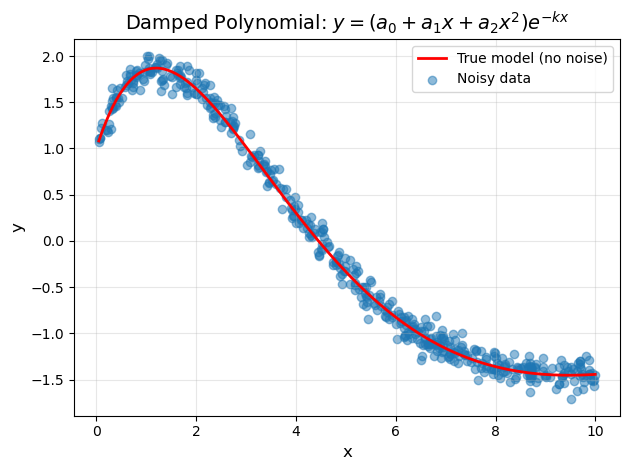

In [9]:
ax = plt.subplot()
ax.plot(x, y_clean, color="red", linewidth=2, label='True model (no noise)')
ax.scatter(x, y_noisy, alpha=0.5, label='Noisy data')
ax.set_xlabel('x', fontsize=12)
ax.set_ylabel('y', fontsize=12)
ax.set_title('Damped Polynomial: $y = (a_0 + a_1 x + a_2 x^2) e^{-kx}$', fontsize=14)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [10]:
def solve_linear_coefficients(k, x, y_observed):
    """
    For a given k, solve for optimal [a0, a1, a2] using SVD.
    
    Model: y = (a0 + a1*x + a2*x^2) * exp(-k*x)
    This is linear in [a0, a1, a2] for fixed k.
    
    Parameters:
    -----------
    k : float
        Decay parameter (fixed)
    x : array
        Independent variable
    y_observed : array
        Observed data
        
    Returns:
    --------
    coeffs : array
        [a0, a1, a2] optimal coefficients
    """
    # Build design matrix A where y = A @ [a0, a1, a2]
    exp_term = np.exp(-k * x)
    A = np.column_stack([
        exp_term,           # coefficient for a0
        x * exp_term,       # coefficient for a1
        x**2 * exp_term     # coefficient for a2
    ])
    
    # Solve using SVD: A @ coeffs = y_observed
    # coeffs = pinv(A) @ y_observed
    U, s, Vt = np.linalg.svd(A, full_matrices=False)
    coeffs = Vt.T @ np.diag(1/s) @ U.T @ y_observed
    
    return coeffs


def loss_function_k_only(k, x, y_observed):
    """
    Loss function that only depends on k.
    For each k, we solve for optimal [a0, a1, a2] using SVD.
    
    Parameters:
    -----------
    k : float or array
        Decay parameter(s)
    x : array
        Independent variable
    y_observed : array
        Observed data
        
    Returns:
    --------
    mse : float
        Mean squared error with optimal linear coefficients
    """
    # Handle case where k might be passed as array from optimizer
    if isinstance(k, np.ndarray):
        k = k[0]
    
    # Solve for optimal linear coefficients given k
    a0, a1, a2 = solve_linear_coefficients(k, x, y_observed)
    
    # Calculate predictions
    y_pred = (a0 + a1*x + a2*x**2) * np.exp(-k*x)
    
    # Mean squared error
    mse = np.mean((y_observed - y_pred)**2)
    
    return mse

In [11]:
# Initial guess for k
k_initial = 0.5

# Run Nelder-Mead optimization to find optimal k
print("Running Nelder-Mead optimization...")
k_optimal = fmin(loss_function_k_only, k_initial, args=(x, y_noisy), 
                 xtol=1e-8, ftol=1e-8, disp=True)

# Extract k value (fmin returns an array)
k_optimal = k_optimal[0]

# Now solve for optimal linear coefficients given k_optimal
a0_opt, a1_opt, a2_opt = solve_linear_coefficients(k_optimal, x, y_noisy)

# Display results
print("\n" + "="*50)
print("OPTIMIZATION RESULTS")
print("="*50)
print("\nTrue parameters:")
print(f"  a0 = {a0_true:.4f}")
print(f"  a1 = {a1_true:.4f}")
print(f"  a2 = {a2_true:.4f}")
print(f"  k  = {k_true:.4f}")

print("\nOptimized parameters:")
print(f"  a0 = {a0_opt:.4f}")
print(f"  a1 = {a1_opt:.4f}")
print(f"  a2 = {a2_opt:.4f}")
print(f"  k  = {k_optimal:.4f}")

print("\nParameter errors:")
print(f"  Δa0 = {abs(a0_opt - a0_true):.4f}")
print(f"  Δa1 = {abs(a1_opt - a1_true):.4f}")
print(f"  Δa2 = {abs(a2_opt - a2_true):.4f}")
print(f"  Δk  = {abs(k_optimal - k_true):.4f}")

# Calculate final MSE
final_mse = loss_function_k_only(k_optimal, x, y_noisy)
print(f"\nFinal MSE: {final_mse:.6f}")

Running Nelder-Mead optimization...
Optimization terminated successfully.
         Current function value: 0.008592
         Iterations: 28
         Function evaluations: 56

OPTIMIZATION RESULTS

True parameters:
  a0 = 1.0000
  a1 = 2.0000
  a2 = -0.5000
  k  = 0.3000

Optimized parameters:
  a0 = 0.9844
  a1 = 2.0218
  a2 = -0.5022
  k  = 0.3007

Parameter errors:
  Δa0 = 0.0156
  Δa1 = 0.0218
  Δa2 = 0.0022
  Δk  = 0.0007

Final MSE: 0.008592


**Exercise**

In this exercise, we will simulate data from a polynomial baseline with a Gaussian peak and fit it using the nested Nelder-Mead and linear regression method.

Our model is 
\begin{equation} 
y = a_0 + a_1 x + a_2 x^2 + a_3 e^{-(x-\mu)^2/(2\sigma^2)}. 
\end{equation} 

You first need to simulate your data. To do so, sample data points $x$ uniformly between 0 and 10. Choose parameters for the polynomial baseline and Gaussian peak. For example, you might use $a_0 = 2.0$, $a_1 = 0.5$, $a_2 = -0.1$ for the polynomial, and $a_3 = 5.0$, $\mu = 5.0$, $\sigma = 0.8$ for the Gaussian peak. Calculate the clean signal using these parameters, then add Gaussian noise to simulate measurement error. A reasonable noise level would be 3% of the maximum signal value. Once you have generated the noisy data, apply the nested optimization approach to recover the parameters. The nonlinear parameters are $\mu$ and $\sigma$, while the linear parameters are $a_0$, $a_1$, $a_2$, and $a_3$. A good initial guess for $\mu$ can be obtained by finding the location of the maximum value in your noisy data.

**Variable Projection Method**

Although I have used this method in my own research, I should note that I am not an expert on the theoretical foundations. The approach described here is commonly known as the variable projection method or separable nonlinear least squares. I will explain the method as I understand it from practical application.

In the variable projection method, we fit data to a nonlinear model that can be written in the form 
\begin{equation} 
y(x) = \sum_{i=1}^N c_i \phi_i(x, \boldsymbol{\theta}), 
\end{equation} 
where $c_i$ are coefficients that appear linearly and $\phi_i$ are basis functions that depend on both $x$ and nonlinear parameters $\boldsymbol{\theta}$. 

For fixed values of $\boldsymbol{\theta}$, the model is linear in the coefficients $c_i$. This allows us to separate the optimization into two parts: an outer optimization over the nonlinear parameters $\boldsymbol{\theta}$ and an inner optimization over the linear coefficients $c_i$.

We examined two non-linear cases in this notebook. 

*Case 1: Damped Polynomial*
\begin{equation}
y(x) = (a_0 + a_1 x + a_2 x^2)e^{-kx}
\end{equation}
The coefficients $(a_0, a_1, a_2)$ appear linearly while $k$ appears nonlinearly.

*Case 2: Polynomial with Gaussian Peak*
\begin{equation}
y(x) = a_0 + a_1 x + a_2 x^2 + a_3 e^{-(x-\mu)^2/(2\sigma^2)}
\end{equation}
The coefficients $(a_0, a_1, a_2, a_3)$ appear linearly while the Gaussian parameters $(\mu, \sigma)$ appear nonlinearly.

**The Method**

For a model with linear coefficients $\mathbf{c} = (c_1, c_2, \ldots, c_N)$ and nonlinear parameters $\boldsymbol{\theta}$, the variable projection method proceeds as follows:

1. Fix the nonlinear parameters $\boldsymbol{\theta}$ at some value
2. Solve for the optimal linear coefficients $\mathbf{c}$ by linear least squares
3. Evaluate the mean squared error with these optimal coefficients
4. Use a nonlinear optimization algorithm (such as Nelder-Mead) to search for the optimal $\boldsymbol{\theta}$
5. Repeat steps 1-3 for each candidate $\boldsymbol{\theta}$ until convergence

**Solving the Linear Subproblem**

For fixed $\boldsymbol{\theta}$, we have a standard linear least squares problem. Given data points $(x_j, y_j)$ for $j = 1, \ldots, M$, we construct the design matrix
\begin{equation}
A = \begin{bmatrix}
\phi_1(x_1, \boldsymbol{\theta}) & \phi_2(x_1, \boldsymbol{\theta}) & \cdots & \phi_N(x_1, \boldsymbol{\theta}) \\
\phi_1(x_2, \boldsymbol{\theta}) & \phi_2(x_2, \boldsymbol{\theta}) & \cdots & \phi_N(x_2, \boldsymbol{\theta}) \\
\vdots & \vdots & \ddots & \vdots \\
\phi_1(x_M, \boldsymbol{\theta}) & \phi_2(x_M, \boldsymbol{\theta}) & \cdots & \phi_N(x_M, \boldsymbol{\theta})
\end{bmatrix}
\end{equation}
and the observation vector $\mathbf{y} = (y_1, y_2, \ldots, y_M)^T$. We solve for the optimal linear coefficients using the singular value decomposition of $A$.

For the polynomial with Gaussian peak example, the design matrix is
\begin{equation}
A = \begin{bmatrix}
1 & x_1 & x_1^2 & e^{-(x_1-\mu)^2/(2\sigma^2)} \\
1 & x_2 & x_2^2 & e^{-(x_2-\mu)^2/(2\sigma^2)} \\
\vdots & \vdots & \vdots & \vdots \\
1 & x_M & x_M^2 & e^{-(x_M-\mu)^2/(2\sigma^2)}
\end{bmatrix}
\end{equation}
where $\mu$ and $\sigma$ are held fixed during the linear solve.

**A Note** In making this exercise, you would not believe how many contrived models I created that upon fitting would get stuck in local minima. For teaching purposes, I wanted something that would work ... hard to do. 

**In the News**
Again, I don't know much about this method. In making this notebook, I cam across the [variable projection method used in neural networks](https://www.youtube.com/watch?v=9JRIOuYTCw8). Here is the [paper](https://arxiv.org/pdf/2007.13171). 